In [2]:
# === AUTHENTICATION ===
from huggingface_hub import login

login()

In [27]:
# Choose and Load Model
# For quick iteration, use GPT-2 (no auth needed, smaller)
# For final analysis, use Llama
import torch
from transformers import AutoModelForCausalLM

USE_LLAMA = True  # Set to True once you want to use Llama

if USE_LLAMA:
    model_name = "meta-llama/Llama-3.2-1B"
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float32,
        device_map="auto"
    )
else:
    model_name = "gpt2"
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float32
    )

print(f"Loaded: {model_name}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Loaded: meta-llama/Llama-3.2-1B
Parameters: 1,235,814,400


In [28]:
# Extract MLP Down-Projection Weights
# This is the layer type we're analyzing

mlp_weights = {}

for name, param in model.named_parameters():
    # GPT-2 naming: transformer.h.{i}.mlp.c_proj.weight
    # Llama naming: model.layers.{i}.mlp.down_proj.weight

    if "mlp.c_proj.weight" in name or "mlp.down_proj.weight" in name:
        # Extract layer number
        layer_num = int(name.split(".")[2])  # Works for both
        mlp_weights[layer_num] = param.detach().cpu().numpy()
        print(f"Layer {layer_num}: {param.shape}")

print(f"\nExtracted {len(mlp_weights)} MLP down-projection matrices")

# === Extract Attention Projection Weights (Llama) ===
attn_weights = {'q': {}, 'k': {}, 'v': {}, 'o': {}}

for name, param in model.named_parameters():
    # Llama naming: model.layers.{i}.self_attn.{q,k,v,o}_proj.weight
    if "self_attn" in name and name.endswith(".weight"):
        layer_num = int(name.split(".")[2])  # works for Llama: model.layers.<i>...

        if "q_proj.weight" in name:
            attn_weights["q"][layer_num] = param.detach().cpu().float().numpy()
        elif "k_proj.weight" in name:
            attn_weights["k"][layer_num] = param.detach().cpu().float().numpy()
        elif "v_proj.weight" in name:
            attn_weights["v"][layer_num] = param.detach().cpu().float().numpy()
        elif "o_proj.weight" in name:
            attn_weights["o"][layer_num] = param.detach().cpu().float().numpy()

print("\nExtracted attention projection matrices:")
for t in ["q","k","v","o"]:
    print(f"  {t}: {len(attn_weights[t])} layers")


Layer 0: torch.Size([2048, 8192])
Layer 1: torch.Size([2048, 8192])
Layer 2: torch.Size([2048, 8192])
Layer 3: torch.Size([2048, 8192])
Layer 4: torch.Size([2048, 8192])
Layer 5: torch.Size([2048, 8192])
Layer 6: torch.Size([2048, 8192])
Layer 7: torch.Size([2048, 8192])
Layer 8: torch.Size([2048, 8192])
Layer 9: torch.Size([2048, 8192])
Layer 10: torch.Size([2048, 8192])
Layer 11: torch.Size([2048, 8192])
Layer 12: torch.Size([2048, 8192])
Layer 13: torch.Size([2048, 8192])
Layer 14: torch.Size([2048, 8192])
Layer 15: torch.Size([2048, 8192])

Extracted 16 MLP down-projection matrices

Extracted attention projection matrices:
  q: 16 layers
  k: 16 layers
  v: 16 layers
  o: 16 layers


In [31]:
# Compare actual quantization error to Shannon bound
def measure_rate_distortion_gap(weights, bits_list=[2, 3, 4, 5, 6, 8]):
    """
    Compare uniform quantization MSE to Shannon bound.
    """
    flat = weights.flatten().astype(np.float32)
    sigma_sq = np.var(flat)

    results = []
    for bits in bits_list:
        # Uniform quantization
        levels = 2 ** bits
        w_min, w_max = flat.min(), flat.max()
        scale = (w_max - w_min) / (levels - 1)
        quantized = np.round((flat - w_min) / scale) * scale + w_min
        mse = np.mean((flat - quantized) ** 2)

        # Shannon bound for Gaussian: R(D) = 0.5 * log2(σ²/D)
        # Rearranged: D_shannon(R) = σ² / 2^(2R)
        # At R = bits, D_shannon = σ² / 4^bits
        d_shannon = sigma_sq / (4 ** bits)

        # Gap: how much worse is uniform vs optimal?
        gap_factor = mse / d_shannon
        gap_bits = 0.5 * np.log2(gap_factor) if gap_factor > 0 else 0

        results.append({
            'bits': bits,
            'mse': mse,
            'd_shannon': d_shannon,
            'gap_factor': gap_factor,
            'gap_bits': gap_bits
        })

    return results

# Measure for one layer
layer = 8
gap_results = measure_rate_distortion_gap(mlp_weights[layer])

print(f"Layer {layer} - Rate-Distortion Gap")
print(f"{'Bits':>6} {'MSE':>12} {'Shannon D':>12} {'Gap (×)':>10} {'Gap (bits)':>10}")
print("-" * 52)
for r in gap_results:
    print(f"{r['bits']:>6} {r['mse']:>12.2e} {r['d_shannon']:>12.2e} "
          f"{r['gap_factor']:>10.2f} {r['gap_bits']:>10.2f}")

Layer 8 - Rate-Distortion Gap
  Bits          MSE    Shannon D    Gap (×) Gap (bits)
----------------------------------------------------
     2     1.40e-02     1.63e-05     857.67       4.87
     3     5.57e-04     4.08e-06     136.68       3.55
     4     4.88e-04     1.02e-06     478.62       4.45
     5     9.41e-05     2.55e-07     369.18       4.26
     6     2.31e-05     6.37e-08     362.22       4.25
     8     1.41e-06     3.98e-09     354.01       4.23


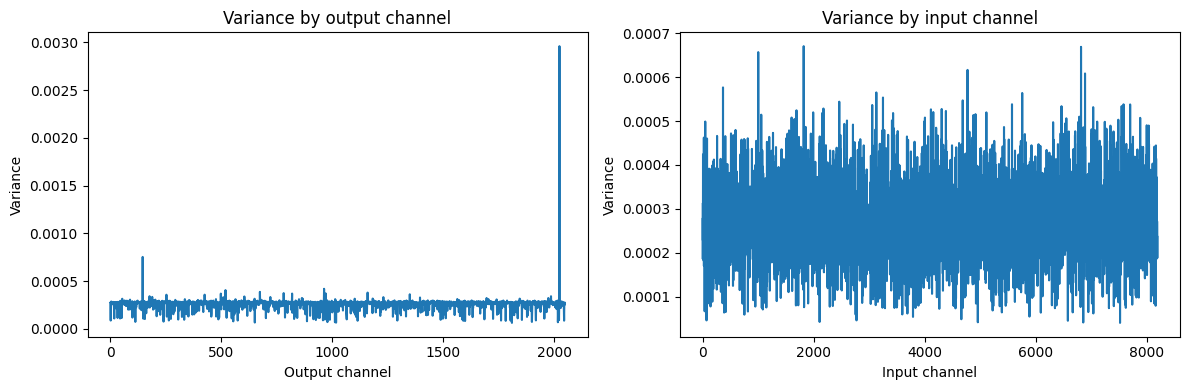

Row variance: min=0.000064, max=0.002960, ratio=46.4×
Col variance: min=0.000040, max=0.000671, ratio=16.7×


In [32]:
# Per-channel variance analysis
# This relates to AWQ insight: some channels matter more

weights = mlp_weights[8]  # Shape: (intermediate_dim, hidden_dim)

# Variance along each dimension
row_variances = np.var(weights.astype(np.float32), axis=1)
col_variances = np.var(weights.astype(np.float32), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(row_variances)
axes[0].set_xlabel('Output channel')
axes[0].set_ylabel('Variance')
axes[0].set_title('Variance by output channel')

axes[1].plot(col_variances)
axes[1].set_xlabel('Input channel')
axes[1].set_ylabel('Variance')
axes[1].set_title('Variance by input channel')

plt.tight_layout()
plt.show()

# How unequal is the variance distribution?
print(f"Row variance: min={row_variances.min():.6f}, max={row_variances.max():.6f}, "
      f"ratio={row_variances.max()/row_variances.min():.1f}×")
print(f"Col variance: min={col_variances.min():.6f}, max={col_variances.max():.6f}, "
      f"ratio={col_variances.max()/col_variances.min():.1f}×")

In [26]:
# Compute Statistics for Each Layer
import numpy as np
from scipy import stats

def compute_weight_stats(weights):
    """Compute distribution statistics for a weight matrix."""
    flat = weights.flatten()

    mu = np.mean(flat)
    sigma = np.std(flat)

    # Moments
    skewness = stats.skew(flat)
    kurtosis = stats.kurtosis(flat) + 3  # scipy returns excess kurtosis

    # Outlier fractions (Gaussian predicts: 0.27%, 0.006%, 0.00006%)
    frac_3sigma = np.mean(np.abs(flat - mu) > 3 * sigma)
    frac_4sigma = np.mean(np.abs(flat - mu) > 4 * sigma)
    frac_5sigma = np.mean(np.abs(flat - mu) > 5 * sigma)

    return {
        'mean': mu,
        'std': sigma,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'frac_3sigma': frac_3sigma,
        'frac_4sigma': frac_4sigma,
        'frac_5sigma': frac_5sigma,
        'min': np.min(flat),
        'max': np.max(flat),
    }

# Compute for all layers
results = {}
for layer_num, weights in sorted(mlp_weights.items()):
    results[layer_num] = compute_weight_stats(weights)

# === Compare kurtosis across weight types ===
print("\nAverage kurtosis by weight type:")

for wtype, layers_dict in attn_weights.items():
    if len(layers_dict) == 0:
        print(f"  {wtype.upper()}_proj: (none found)")
        continue
    kurtosis_vals = [compute_weight_stats(w)["kurtosis"] for w in layers_dict.values()]
    print(f"  {wtype.upper()}_proj: {np.mean(kurtosis_vals):.2f}")

mlp_kurtosis = [results[l]["kurtosis"] for l in results]
print(f"  MLP down: {np.mean(mlp_kurtosis):.2f}")

# Display as table
print(f"{'Layer':<6} {'Mean':>10} {'Std':>10} {'Kurtosis':>10} {'3σ %':>10} {'4σ %':>10}")
print("-" * 60)
for layer_num, stats_dict in results.items():
    print(f"{layer_num:<6} {stats_dict['mean']:>10.6f} {stats_dict['std']:>10.6f} "
          f"{stats_dict['kurtosis']:>10.2f} {stats_dict['frac_3sigma']*100:>10.4f} "
          f"{stats_dict['frac_4sigma']*100:>10.4f}")


Average kurtosis by weight type:
  Q_proj: 5.70
  K_proj: 5.57
  V_proj: 4.43
  O_proj: 6.58
  MLP down: 4.04
Layer        Mean        Std   Kurtosis       3σ %       4σ %
------------------------------------------------------------
0       -0.000004   0.017389       4.00     0.3769     0.0404
1       -0.000001   0.017200       4.10     0.3591     0.0267
2       -0.000003   0.016767       3.76     0.3710     0.0328
3        0.000007   0.015983       3.65     0.3884     0.0325
4       -0.000001   0.015833       3.81     0.4253     0.0385
5        0.000002   0.015982       4.50     0.4471     0.0481
6        0.000005   0.015712       4.99     0.4956     0.0570
7       -0.000003   0.016099       4.79     0.5450     0.0707
8       -0.000004   0.016154       4.24     0.5139     0.0566
9       -0.000001   0.016566       4.15     0.4822     0.0503
10       0.000003   0.016857       3.91     0.4328     0.0418
11      -0.000003   0.017260       3.48     0.3979     0.0286
12       0.000001   0.

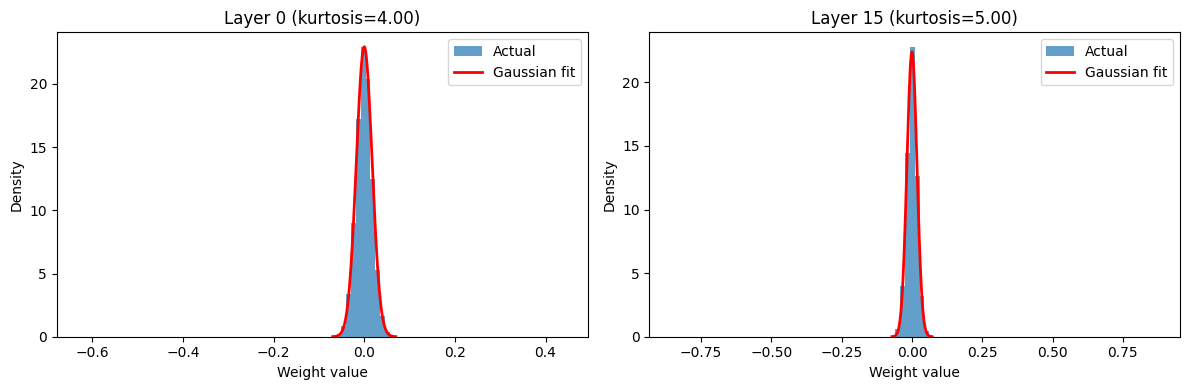

In [24]:
# Visualize - Histogram with Gaussian Overlay
import matplotlib.pyplot as plt

def plot_weight_histogram(weights, layer_num, ax):
    """Plot histogram of weights with Gaussian overlay."""
    flat = weights.flatten()
    mu, sigma = np.mean(flat), np.std(flat)

    # Histogram
    ax.hist(flat, bins=100, density=True, alpha=0.7, label='Actual')

    # Gaussian overlay
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 200)
    gaussian = stats.norm.pdf(x, mu, sigma)
    ax.plot(x, gaussian, 'r-', linewidth=2, label='Gaussian fit')

    ax.set_xlabel('Weight value')
    ax.set_ylabel('Density')
    ax.set_title(f'Layer {layer_num} (kurtosis={results[layer_num]["kurtosis"]:.2f})')
    ax.legend()

# Plot first and last layer
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

first_layer = min(mlp_weights.keys())
last_layer = max(mlp_weights.keys())

plot_weight_histogram(mlp_weights[first_layer], first_layer, axes[0])
plot_weight_histogram(mlp_weights[last_layer], last_layer, axes[1])

plt.tight_layout()
plt.show()

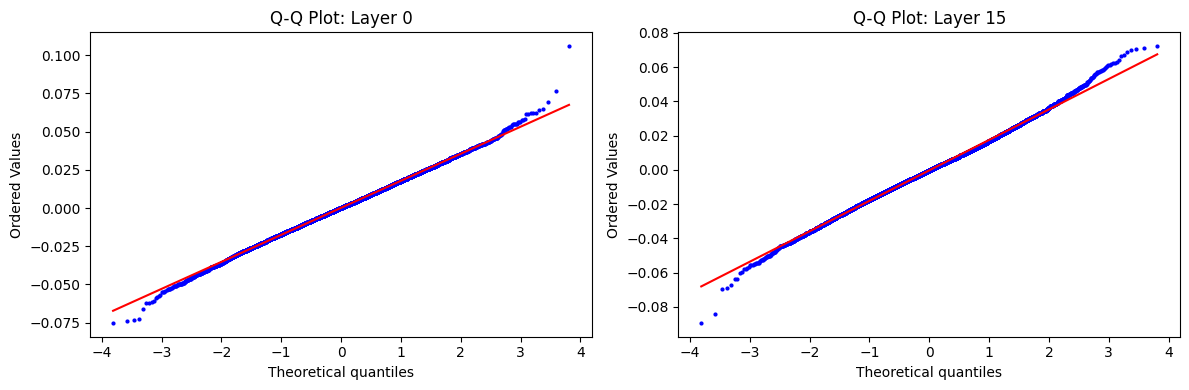

In [16]:
# Q-Q Plot (Quantile-Quantile)
# This shows tail behavior more clearly than histogram

def plot_qq(weights, layer_num, ax):
    """Q-Q plot comparing to Gaussian."""
    flat = weights.flatten()

    # Subsample if too many points (for speed)
    if len(flat) > 10000:
        flat = np.random.choice(flat, 10000, replace=False)

    stats.probplot(flat, dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot: Layer {layer_num}')
    ax.get_lines()[0].set_markersize(2)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_qq(mlp_weights[first_layer], first_layer, axes[0])
plot_qq(mlp_weights[last_layer], last_layer, axes[1])
plt.tight_layout()
plt.show()

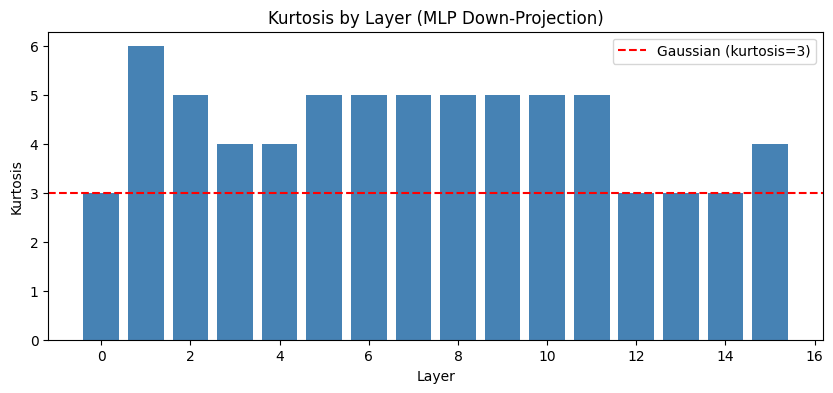


Average kurtosis: 4.38
→ Weights are HEAVY-TAILED (more outliers than Gaussian)


In [17]:
# Cell 7: Kurtosis Across Layers
layers = sorted(results.keys())
kurtosis_values = [results[l]['kurtosis'] for l in layers]

plt.figure(figsize=(10, 4))
plt.bar(layers, kurtosis_values, color='steelblue')
plt.axhline(y=3, color='red', linestyle='--', label='Gaussian (kurtosis=3)')
plt.xlabel('Layer')
plt.ylabel('Kurtosis')
plt.title('Kurtosis by Layer (MLP Down-Projection)')
plt.legend()
plt.show()

# Print interpretation
avg_kurtosis = np.mean(kurtosis_values)
print(f"\nAverage kurtosis: {avg_kurtosis:.2f}")
if avg_kurtosis > 3:
    print("→ Weights are HEAVY-TAILED (more outliers than Gaussian)")
elif avg_kurtosis < 3:
    print("→ Weights are LIGHT-TAILED (fewer outliers than Gaussian)")
else:
    print("→ Weights are approximately Gaussian")

In [18]:
# Investigate the extreme kurtosis layers
import numpy as np

def investigate_layer(weights, layer_num):
    flat = weights.flatten()
    mu, sigma = np.mean(flat), np.std(flat)

    print(f"\n=== Layer {layer_num} ===")
    print(f"Shape: {weights.shape}")
    print(f"Total weights: {len(flat):,}")
    print(f"Mean: {mu:.6f}, Std: {sigma:.6f}")
    print(f"Min: {np.min(flat):.4f}, Max: {np.max(flat):.4f}")
    print(f"Range in σ units: [{(np.min(flat)-mu)/sigma:.1f}σ, {(np.max(flat)-mu)/sigma:.1f}σ]")

    # Count extreme outliers
    for threshold in [3, 4, 5, 6, 7, 8]:
        count = np.sum(np.abs(flat - mu) > threshold * sigma)
        if count > 0:
            print(f"  Beyond {threshold}σ: {count:,} weights ({count/len(flat)*100:.4f}%)")

    # Show the actual extreme values
    sorted_flat = np.sort(flat)
    print(f"5 smallest: {sorted_flat[:5]}")
    print(f"5 largest: {sorted_flat[-5:]}")

# Investigate the extreme layers
investigate_layer(mlp_weights[0], 0)
investigate_layer(mlp_weights[1], 1)
investigate_layer(mlp_weights[6], 6)  # A "normal" layer for comparison


=== Layer 0 ===
Shape: (2048, 8192)
Total weights: 16,777,216
Mean: -0.000004, Std: 0.017059
Min: -0.6250, Max: 0.4395
Range in σ units: [-36.6σ, 25.8σ]
  Beyond 3σ: 73,320 weights (0.4370%)
  Beyond 4σ: 7,815 weights (0.0466%)
  Beyond 5σ: 2,442 weights (0.0146%)
  Beyond 6σ: 1,133 weights (0.0068%)
  Beyond 7σ: 564 weights (0.0034%)
  Beyond 8σ: 307 weights (0.0018%)
5 smallest: [-0.625  -0.578  -0.5703 -0.5703 -0.4707]
5 largest: [0.334  0.3457 0.3906 0.4316 0.4395]

=== Layer 1 ===
Shape: (2048, 8192)
Total weights: 16,777,216
Mean: -0.000001, Std: 0.016785
Min: -0.7109, Max: 0.6094
Range in σ units: [-42.3σ, 36.3σ]
  Beyond 3σ: 73,634 weights (0.4389%)
  Beyond 4σ: 5,375 weights (0.0320%)
  Beyond 5σ: 1,298 weights (0.0077%)
  Beyond 6σ: 606 weights (0.0036%)
  Beyond 7σ: 347 weights (0.0021%)
  Beyond 8σ: 232 weights (0.0014%)
5 smallest: [-0.711  -0.5703 -0.5547 -0.338  -0.33  ]
5 largest: [0.4434 0.4785 0.4902 0.5    0.6094]

=== Layer 6 ===
Shape: (2048, 8192)
Total weights: 

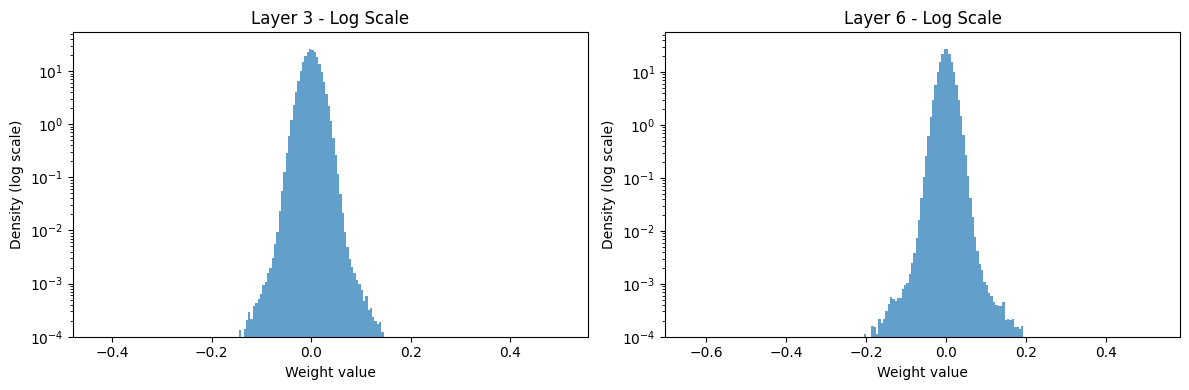

In [19]:
# Log-scale histogram to see tails
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, layer_num in zip(axes, [3, 6]):
    flat = mlp_weights[layer_num].flatten()

    # Log-scale y-axis reveals tail behavior
    ax.hist(flat, bins=200, density=True, alpha=0.7)
    ax.set_yscale('log')
    ax.set_xlabel('Weight value')
    ax.set_ylabel('Density (log scale)')
    ax.set_title(f'Layer {layer_num} - Log Scale')
    ax.set_ylim(1e-4, None)  # Cut off very small densities

plt.tight_layout()
plt.show()